<h1 style="color:cyan; font-weight: bold;">The Best Simple Model is Linear Regression with Backward Elimination</h1>

### Import Dependencies

In [12]:
!pip3 install gdown


from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statistics
import seaborn as sns
from math import exp

Defaulting to user installation because normal site-packages is not writeable


### Import Dataset from Extracted from Feature Engineering (Already Contain Time Series Components)

In [ ]:
# Y_train_url = "https://docs.google.com/spreadsheets/d/1Ntv_DgT7E5MxrZFBfTzvYaf_6MxUNBPBwPsZbOurJfQ/edit?usp=sharing"
# X_test_url = "https://docs.google.com/spreadsheets/d/1zvCu5MbOpuWKG5_WsWPGpzz4QPhUAUU5f2trjFOGffk/edit#gid=1405820802"
# Y_test_url = "https://docs.google.com/spreadsheets/d/1XhTqsdm1kp-yyNz1vM-tkSpzgLSt2WPh3qmWUI9RS0Q/edit#gid=54759849"

In [23]:
import requests
from io import BytesIO
# Define the direct URLs for the CSV files
Y_train_url = "https://drive.google.com/uc?id=1uCkugZ30YCAL3CyEj4vLRyR4KU-WH7dj&export=download"
X_test_url = "https://drive.google.com/uc?id=1yU6uCm8YYGd6ok_Ox0O8TwLLzxdshOPQ&export=download"
Y_test_url = "https://drive.google.com/uc?id=1dOm6vCVqncJUnPGvhlU6tlrt3GnVA4SK&export=download"

# Function to download and read CSV files
def download_and_read_csv(url):
    response = requests.get(url)
    if response.status_code == 200:
        content = BytesIO(response.content)
        return pd.read_csv(content)
    else:
        print(f"Failed to download CSV from {url}")
        return None

# Download and read the CSV files
Y_train = download_and_read_csv(Y_train_url)
X_test = download_and_read_csv(X_test_url)
Y_test = download_and_read_csv(Y_test_url)

# Check the shapes of the dataframes
print("Y_train.shape >> ", Y_train.shape)
print("X_test.shape >> ", X_test.shape)
print("Y_test.shape >> ", Y_test.shape)

Y_train.shape >>  (33480, 35)
X_test.shape >>  (1392, 278)
Y_test.shape >>  (1392, 35)


### You have to download and import X_train Manually because the file is large

In [25]:
# Link to download X_train https://drive.google.com/file/d/1g-WchMrKqXkk8P9yY7Qk1v4MnMg5zXHo/view?usp=drive_link

X_train = pd.read_csv("./Beijing_simple_model_xtrain.csv")
X_train.shape

(33480, 278)

### Backward Elimination Function

In [33]:
!pip3 install statsmodels

#Backward Elimination. Evaluation is done based on the significance value (p-value)
import statsmodels.api as sm

def backward_elimination(X_train, Y_train, X_test, Y_test, significance_level=0.05):

    boolean_columns = ['Season_Fall', 'Season_Spring', 'Season_Summer', 'Season_Winter']

    # Convert boolean columns to integers
    X_train[boolean_columns] = X_train[boolean_columns].astype(int)
    X_test[boolean_columns] = X_test[boolean_columns].astype(int)

    # Concatenate X_train and X_test along axis 0 (rows)
    X_combined_df = pd.concat([X_train, X_test], axis=0)
    Y_combined_df = pd.concat([Y_train, Y_test], axis=0)

    X = X_combined_df
    y = Y_combined_df['Target_AQHI_1h']

    num_features = X.shape[1]

    # X = sm.add_constant(X)
    for i in range(num_features):
        
        # Fit the model
        model = sm.OLS(y, X).fit()
        # Get p-values for each feature
        p_values = model.pvalues
        # Find the feature with the highest p-value
        max_p_value = p_values.max()
        if max_p_value > significance_level:
            # Remove the feature with the highest p-value
            max_p_value_index = p_values.argmax()
            X = X.drop(columns=X.columns[max_p_value_index])
        else:
            # If all p-values are below the significance level, break the loop
            break
    return X




Defaulting to user installation because normal site-packages is not writeable


### Compute Metrics

In [32]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

#function to evaluate the model
def model_evaluation(y_test: np.ndarray, y_pred: np.ndarray):
    """
    Model Evaluation, code by Chinedu Ifediorah
    Compute the Mean Absolute Error, Mean Square Error and Mean Directional Accuracy

    :param np.ndarray y_test: The array with the actual values to be predicted
    :param np.ndarray y_pred: The array with the forecasted values - must
       align with the actual values
    :return: Mean Absolute Error, Mean Squared Error, Mean Directional Accuracy
    :rtype: tuple of floats
    """

    # Compute Mean Absolute Error (MAE)
    mae_error = mean_absolute_error(y_test, y_pred)

    # Compute Mean Squared Error (MSE)
    mse_error = mean_squared_error(y_test, y_pred)

    return mae_error, mse_error

### Plot Response

In [27]:
def plot_response(y_pred, y_test):

    x_values = np.arange(len(y_test))

    plt.figure(figsize=(12, 6))

    # Plotting y_test
    plt.plot(x_values, y_test, label='y_test')

    # Plotting y_pred on top of y_test
    plt.plot(x_values, y_pred, label='y_pred', linestyle='--')

    # Adding labels and legend
    plt.xlabel('Index')
    plt.ylabel('Values')
    plt.legend()

    # Showing the plot
    plt.show()

### Best Simple Model

In [41]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import math


#function for simple linear regression
def linear_regression_model(X_train, Y_train, X_test, Y_test, target = 'Target_AQHI_1h'):

    # Perform Backward Elimination
    X_selected = backward_elimination(X_train.copy(), Y_train.copy(), X_test.copy(), Y_test.copy())

    X_selected_columns = list(X_selected.columns)

    X_train = X_train.loc[:, X_selected_columns]
    y_train = Y_train[target]
    X_test = X_test.loc[:, X_selected_columns]
    y_test = Y_test[target]

    # Initialize the standard scaler
    scaler = StandardScaler()

    # Fit and transform the training data
    X_train_scaled = scaler.fit_transform(X_train)
    
    # Transform the test data using the same scaler
    X_test_scaled = scaler.transform(X_test)

    # Initialize the linear regression model
    linear_regression_model = LinearRegression()

    # Train the model on the training data
    linear_regression_model.fit(X_train_scaled, y_train)

    # Generate predictions on the test dataset
    pred = linear_regression_model.predict(X_test_scaled)

    #Evaluate the model
    mae, mse = model_evaluation(y_test.values, pred)

    return linear_regression_model, pred, mae, mse

Mean Absolute Error (MAE): 0.3261992765525644
Mean Squared Error (MSE): 0.2921659039284562
Root Mean Squared Error (RMSE): 0.5405237311427281


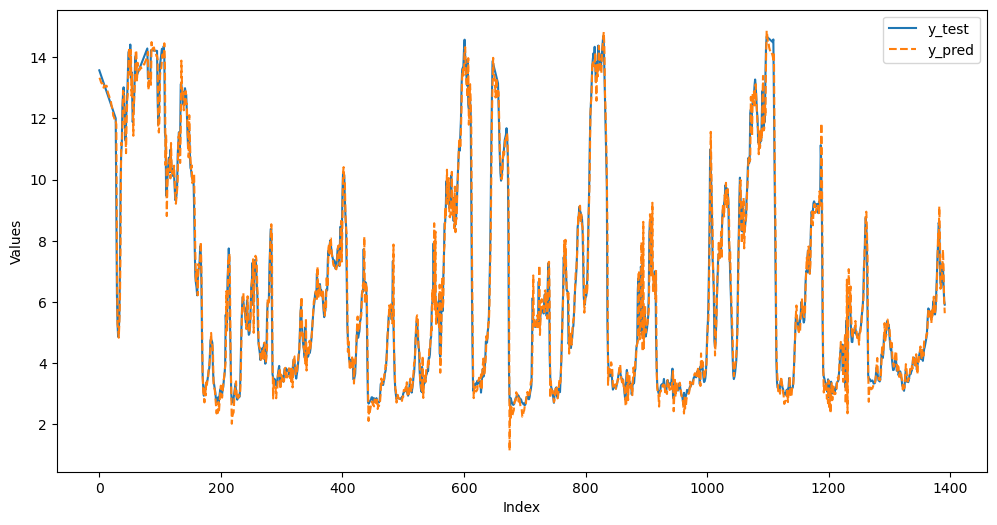

In [42]:
linear_model_reduced, linear_model_reduced_pred, linear_model_reduced_mae, linear_model_reduced_mse = linear_regression_model(
    X_train.copy(),
    Y_train.copy(),
    X_test.copy(),
    Y_test.copy()
  )

# Print the computed metrics
print("Mean Absolute Error (MAE):", linear_model_reduced_mae)
print("Mean Squared Error (MSE):", linear_model_reduced_mse)
print("Root Mean Squared Error (RMSE):", math.sqrt(linear_model_reduced_mse))

plot_response(np.array(linear_model_reduced_pred), np.array(Y_test['Target_AQHI_1h']))

### It would take about 2mins to run because we are performing backward elimination with pvalues